<a href="https://colab.research.google.com/github/Equipe16-IAA/IAA012-FrameworksIA/blob/main/03_recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 - Sistemas de Recomendação

---

# Exercico 03: Criar um sistema de recomendação de livro

#### 1. Importação das bibliotecas

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
#### 2. Importação dos dados

In [ ]:
#!wget https://marlonprudente.eng.br/files/Base_livros.csv

df = pd.read_csv("Base_livros.csv")
df.head()

--2024-12-07 13:05:17--  https://marlonprudente.eng.br/files/Base_livros.csv
Resolving marlonprudente.eng.br (marlonprudente.eng.br)... 138.36.12.12
Connecting to marlonprudente.eng.br (marlonprudente.eng.br)|138.36.12.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12843775 (12M) [application/octet-stream]
Saving to: ‘Base_livros.csv’

Base_livros.csv     100%[===================>]  12.25M  5.02MB/s    in 2.4s    

2024-12-07 13:05:21 (5.02 MB/s) - ‘Base_livros.csv’ saved [12843775/12843775]



<ipython-input-2-92ac0f28e27d>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Base_livros.csv")


,ISBN,Titulo,Autor,Ano,Editora,ID_usuario,Notas,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,276725,0,NaN,NaN,NaN,NaN,NaN,NaN
1,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,276726,2,NaN,NaN,NaN,NaN,NaN,NaN
2,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,276727,6,NaN,NaN,NaN,NaN,NaN,NaN
3,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,276729,1,NaN,NaN,NaN,NaN,NaN,NaN
4,399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,276729,9,NaN,NaN,NaN,NaN,NaN,NaN


---
#### 3. Conversão de userId e movieId para categoria

In [ ]:
# userId e movieId não estão no formato certo para usar
# Embeddings > devem ser categóricos

df = df.drop(columns=["Unnamed: 7", "Unnamed: 8", "Unnamed: 9" ,"Unnamed: 10" ,"Unnamed: 11" ,"Unnamed: 12"])
df.head()



,ISBN,Titulo,Autor,Ano,Editora,ID_usuario,Notas
0,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,276725,0
1,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,276726,2
2,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,276727,6
3,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,276729,1
4,399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,276729,9


In [ ]:
# prompt: transformar coluna Notas do df em int

# Convertendo a coluna 'Notas' para tipo numérico (int)
df['Notas'] = pd.to_numeric(df['Notas'], errors='coerce').fillna(0).astype(int)
df['ISBN'] = pd.to_numeric(df['ISBN'], errors='coerce').fillna(0).astype(int)
df['ID_usuario'] = pd.to_numeric(df['ID_usuario'], errors='coerce').fillna(0).astype(int)

df[df['Notas'] > 10] = 10

df.head()

,ISBN,Titulo,Autor,Ano,Editora,ID_usuario,Notas
0,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,276725,0
1,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,276726,2
2,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,276727,6
3,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,276729,1
4,399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,276729,9


In [ ]:
# Dimensões
N = len(set(df.ID_usuario))
M = len(set(df.ISBN))

# dimensão do embedding (tentar outros)
K = 10

#### 4. Criar o modelo

In [ ]:
# usuário
u = Input(shape=(1,))
u_emb = Embedding(N, K)(u) # saída : num_samples, 1, K
u_emb = Flatten()(u_emb)   # saída : num_samples, K

# filme
m = Input(shape=(1,))
m_emb = Embedding(M, K)(m)  # saída : num_samples, 1, K
m_emb = Flatten()(m_emb)    # saída : num_samples, K

x = Concatenate()([u_emb, m_emb])

x = Dense(1024, activation="relu")(x)
x = Dense(1)(x)

model = Model(inputs=[u, m], outputs=x)

#### 5. Compilação do modelo

In [ ]:
model.compile(
    loss="mse",
    optimizer=SGD(learning_rate=0.08, momentum=0.9)
)

#### 6. Separação dos dados e pré-processamento


In [ ]:
user_ids, movie_ids, ratings = shuffle(df.ID_usuario, df.ISBN, df.Notas)

Ntrain = int(0.8 * len(ratings)) # separar os dados 80% x 20%

train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]
test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# centralizar as notas
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

#### 7. Treinamento do modelo

In [ ]:
epochs = 100
r = model.fit(
    x=[train_user, train_movie],
    y=train_ratings,
    epochs=epochs,
    batch_size=1024,
    verbose=2, # não imprime o progresso
    validation_data=([test_user, test_movie], test_ratings)
)

Epoch 1/100
101/101 - 3s - 34ms/step - loss: 8.7190 - val_loss: 8.4430
Epoch 2/100
101/101 - 0s - 2ms/step - loss: 8.3786 - val_loss: 8.4458
Epoch 3/100
101/101 - 0s - 2ms/step - loss: 8.3695 - val_loss: 8.4331
Epoch 4/100
101/101 - 0s - 2ms/step - loss: 8.3470 - val_loss: 8.4247
Epoch 5/100
101/101 - 0s - 3ms/step - loss: 8.3368 - val_loss: 8.4340
Epoch 6/100
101/101 - 0s - 2ms/step - loss: 8.3361 - val_loss: 8.4528
Epoch 7/100
101/101 - 0s - 3ms/step - loss: 8.3228 - val_loss: 8.4374
Epoch 8/100
101/101 - 0s - 2ms/step - loss: 8.3126 - val_loss: 8.4570
Epoch 9/100
101/101 - 0s - 3ms/step - loss: 8.2910 - val_loss: 8.4577
Epoch 10/100
101/101 - 0s - 3ms/step - loss: 8.2885 - val_loss: 8.4679
Epoch 11/100
101/101 - 0s - 3ms/step - loss: 8.2664 - val_loss: 8.4952
Epoch 12/100
101/101 - 0s - 3ms/step - loss: 8.2552 - val_loss: 8.4673
Epoch 13/100
101/101 - 0s - 3ms/step - loss: 8.2543 - val_loss: 8.4942
Epoch 14/100
101/101 - 0s - 3ms/step - loss: 8.2369 - val_loss: 8.5458
Epoch 15/100
1

#### 8. Plotar a função de perda

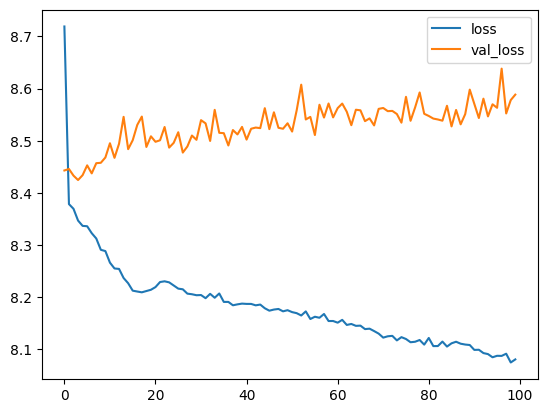

In [ ]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

### 9. Recomendações para o usuário 276729

In [ ]:
# Gerar o array com o usuário único
# repete a quantidade de filmes
input_usuario = np.repeat(a=276729, repeats=M) #10058 276729
film = np.array(list(set(movie_ids)))

preds = model.predict( [input_usuario, film] )

# descentraliza as predições
rat = preds.flatten() + avg_rating

# índice da maior nota
idx = np.argmax(rat)
book_data = df[df['ISBN'] == film[idx]]
print("Recomendação: Filme - ", film[idx], " / ", rat[idx] , "*")
print("Nome: ", book_data['Titulo'].values[0])

3107/3107 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Recomendação: Filme -  373293062  /  4.967702 *
Nome:  High Country Hero (Harlequin Historical Series)


---

# Fim do código